# Subspace learning using lifting functions

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
import joblib
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

AttributeError: module 'wrapt' has no attribute 'ObjectProxy'

## Gathering training data

In [60]:
###############################
N = 5000
dt = 1e-2
pi = np.pi
nb_parts = 100
n_training = 6
n_testing = 3
n_folds = n_training + n_testing
###############################
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.2, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
###############################
pend.ref = np.empty(shape=[n_folds,N])
for j in range(n_folds):
    x_train = 0
    phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
    A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    for i in range(nb_parts):
        x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    x_train = x_train/max(max(x_train),-min(x_train))*pi
    pend.ref[j,:] = x_train
###############################
Kp, Ki, Kd = 50, 20, 5
pend.U = np.zeros(shape=[n_folds,N-1])
pend.X = np.zeros(shape=[n_folds,2,N])
###############################
for j in range(n_folds):
    pend.X[j,0,0] = pend.ref[j,0]
    for i in range(N-1):
        pend.U[j,i] = PID(pend.X[j,:,:], i, pend.ref[j,i], Kp, Kd, Ki, pend.dt, 20, limit=[-20,20])[0] 
        pend.X[j,:,i+1] = RK4(pend.dynamics, pend.X[j,:,i], pend.U[j,i], pend.dt, type='controller-step-by-step')
        
# Learn on differences ########
pend.dX = np.diff(pend.X, axis=2) # Delta X's
pend.dU = np.diff(pend.U, axis=1) # Delta U's

## Learning linear dynamics model

### Using Bayesian optimisation

In [92]:
# Hyperparameters space
nx_low, nx_high = 1, 20
nu_low, nu_high = 0, 5
d_low, d_high = 1, np.int(.9*pend.N/max(nx_high,nu_high))
print('Delay max : ',d_high)
#######################################################
space = {
    "x_dimension": hp.quniform("x_dimension", nx_low, nx_high, 1),
    "u_dimension": hp.quniform("u_dimension", nu_low, nu_high, 1),
    "traj_delay": hp.quniform("traj_delay", d_low, d_high, 1),
}
#######################################################
loss_traj = np.empty(shape=[n_training])
loss_res = np.empty(shape=[n_training])
loss_U = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])
U_res = np.empty(shape=[n_training])

# LQR simulation settings
model = SLFC(pend.X[0,:,:], pend.U[0,:]) # Initialize model paramters

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size

t_interval = pend.dt

def hyperparameters_tuning(params):
    
    # Model parameters
    nx = np.int(params["x_dimension"])
    nu = np.int(params["u_dimension"])
    d = np.int(params["traj_delay"])
    
    # Models training and simulation
    for fold in range(n_training):
        
        model = SLFC(pend.X[fold,:,:], pend.U[fold,:])
        model.delayEmbeddings(nx=nx,nu=nu,d=d)
        model.EDMD()
        model.Simulate(pend.X[fold,:,:], pend.U[fold,:])
        # LQR loss ##############################
#         Xc, X_lift = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.lift_dim,model.N])
#         Xc[:,0], X_lift[:,0] = pend.X[fold,:,0], pinv(model.C)@Xc[:,0]
#         Uc = np.empty(shape=[model.N-1])
        
#         model.ConstructLQR(x_std=1e6, u_std=0., dt=pend.dt, ref=pend.ref[fold,:])
#         model.LQR_simulate(X0=pend.X[fold,:,0])
        
#         # Simulate the closed-loop trajectory for the non-linear dynamics
#         for i in range(model.N-1):

#             Uc[i] = (model.LQR.get_command(X_lift[:,i],i))
#             if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
#             if Uc[i] <= u_max[0]: Uc[i] = u_max[0]

#             Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
#             X_lift[:,i+1] = pinv(model.C)@Xc[:,i+1]
            
        loss_traj[fold] = model.RMSE(X_pred=model.X_sim, X_true=pend.X[fold,:,:]) 
#         loss_LQR[fold] = model.RMSE(X_pred=Xc, X_true=pend.X[fold,:,:])
#         loss_U[fold] = model.RMSE(X_pred=Uc[:,np.newaxis].T, X_true=pend.U[fold,:,np.newaxis].T)

#     loss = loss_LQR.sum()/n_training + loss_res.sum()/n_training*Q_traj + U_res.sum()*Q_u
    loss = (loss_traj.sum())/n_training
    
    print('Hyperparameters {}'.format(params), 'Loss {}'.format(loss))
    print(loss_traj)
    return {"loss":loss, "status":STATUS_OK}
#######################################################
# trials = joblib.load('hyperopt_trials.pkl')
trials = Trials()

best = fmin(
    fn = hyperparameters_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 100, 
    trials = trials
)

joblib.dump(trials, 'hyperopt_trials.pkl')

print('Best hyperparameters {}'.format(best))

Delay max :  225
Hyperparameters {'traj_delay': 150.0, 'u_dimension': 5.0, 'x_dimension': 6.0}                                          
Loss 2276761.5833678218                                                                                                
[1.86922e+03 6.04557e+03 2.23326e+03 9.44380e+03 1.31342e+07 5.06767e+05]                                              
Hyperparameters {'traj_delay': 11.0, 'u_dimension': 1.0, 'x_dimension': 10.0}                                          
Loss 2.0281913411507057e+32                                                                                            
[1.05198e+16 1.31045e+17 6.63310e+21 1.27313e+27 9.06085e+15 1.21691e+33]                                              
Hyperparameters {'traj_delay': 66.0, 'u_dimension': 4.0, 'x_dimension': 6.0}                                           
Loss 6.68859518184554e+21                                                                                              
[1.20400e+18 1.90079e+1

C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:590: RuntimeWarning: overflow encountered in square
  #         N_ = np.eye(self.lift_dim) - pinv(self.C) @ self.C # Nullspace projection operator

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Hyperparameters {'traj_delay': 22.0, 'u_dimension': 3.0, 'x_dimension': 2.0}                                           
Loss 99.98782203497281                                                                                                 
[99.99342 99.98614 99.99751 99.99739 99.96231 99.99016]                                                                
Hyperparameters {'traj_delay': 39.0, 'u_dimension': 1.0, 'x_dimension': 16.0}                                          
Loss 5870804462476986.0                                                                                                
[3.52248e+16 6.68720e+05 1.02355e+05 1.03399e+04 1.66696e+06 8.53994e+03]                                              
  8%|███▉                                             | 8/100 [00:10<01:58,  1.29s/trial, best loss: 99.98782203497281]

C:\Users\cedri\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2560: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real



Hyperparameters {'traj_delay': 7.0, 'u_dimension': 5.0, 'x_dimension': 11.0}                                           
Loss inf                                                                                                               
[2.75875e+113 6.98861e+083 6.91036e+063          inf 2.48974e+058                                                      
 8.51786e+126]
Hyperparameters {'traj_delay': 223.0, 'u_dimension': 1.0, 'x_dimension': 14.0}                                         
Loss 3.006113808595022e+68                                                                                             
[1.80367e+69 8.16292e+42 3.35390e+38 2.33848e+54 1.93108e+36 1.21111e+58]                                              
Hyperparameters {'traj_delay': 153.0, 'u_dimension': 3.0, 'x_dimension': 19.0}                                         
Loss 2.297952343487969e+112                                                                                            
[2.17676e+037 2.53998e+05

KeyboardInterrupt: 

In [319]:
lg.norm(np.empty(shape=[1,6]),axis=0).shape

(6,)

89.55325329458631


(Text(0, 0.5, 'Degrees'), Text(0, 0.5, 'Degrees/sec'))

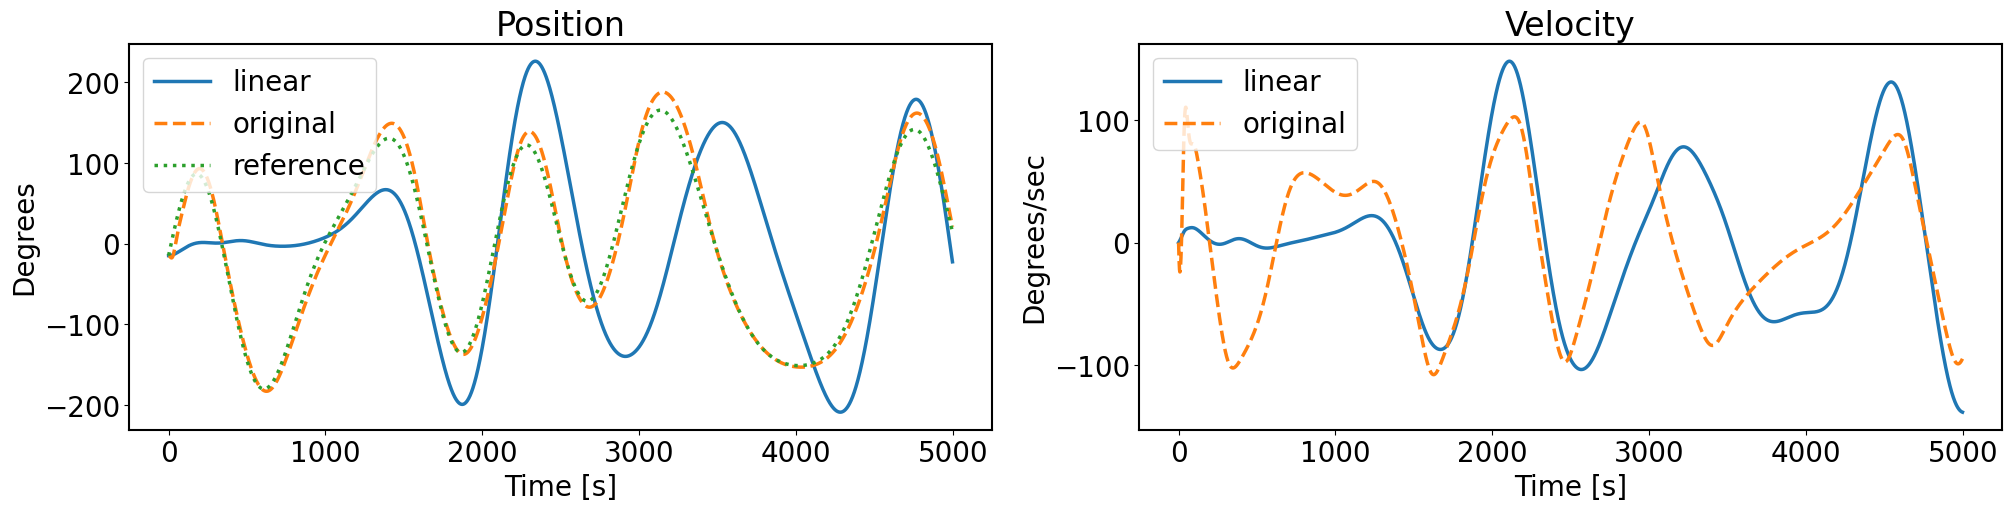

In [91]:
traj = 2
model = SLFC(pend.X[traj,:,:], pend.U[traj,:])
model.delayEmbeddings(nx=4,nu=1,d=230)
model.EDMD()
model.Simulate(pend.X[traj,:,:], pend.U[traj,:])

print(model.RMSE(model.X_sim,pend.X[traj,:,:]))

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(pend.T,rad2deg(model.X_sim[0,:]),label='linear'), ax[1].plot(pend.T,rad2deg(model.X_sim[1,:]),label='linear')
ax[0].plot(pend.T,rad2deg(pend.X[traj,0,:]),label='original',linestyle='dashed'), ax[1].plot(pend.T,rad2deg(pend.X[traj,1,:]),label='original',linestyle='dashed')
ax[0].plot(pend.T,rad2deg(np.array(pend.ref[traj,:])),linestyle='dotted',label='reference'), ax[0].legend(), ax[1].legend()
ax[0].set_title('Position'), ax[1].set_title('Velocity')
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Degrees'), ax[1].set_ylabel('Degrees/sec')

## Train LQR planner

In [1]:
traj = 0
model.Simulate(pend.X[traj,:,:], pend.U[traj,:])
model.ConstructLQR(x_std=1e7, u_std=2., dt=pend.dt, ref=pend.ref[traj,:])
model.LQR_simulate(X0=pend.X[traj,:,0])

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[traj,0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[traj,1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

print(model.LQR_U[:,:,:].shape)
ax[1,0].plot(pend.T[:model.N-1], pend.U[traj,:], label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model.N-1], (model.LQR_U[0,:,:].T).T, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

NameError: name 'model' is not defined

In [224]:
model.K.shape

(4999, 1, 2)

LQR cost :  24571034.73988452
LQR cost :  218426799.97676152


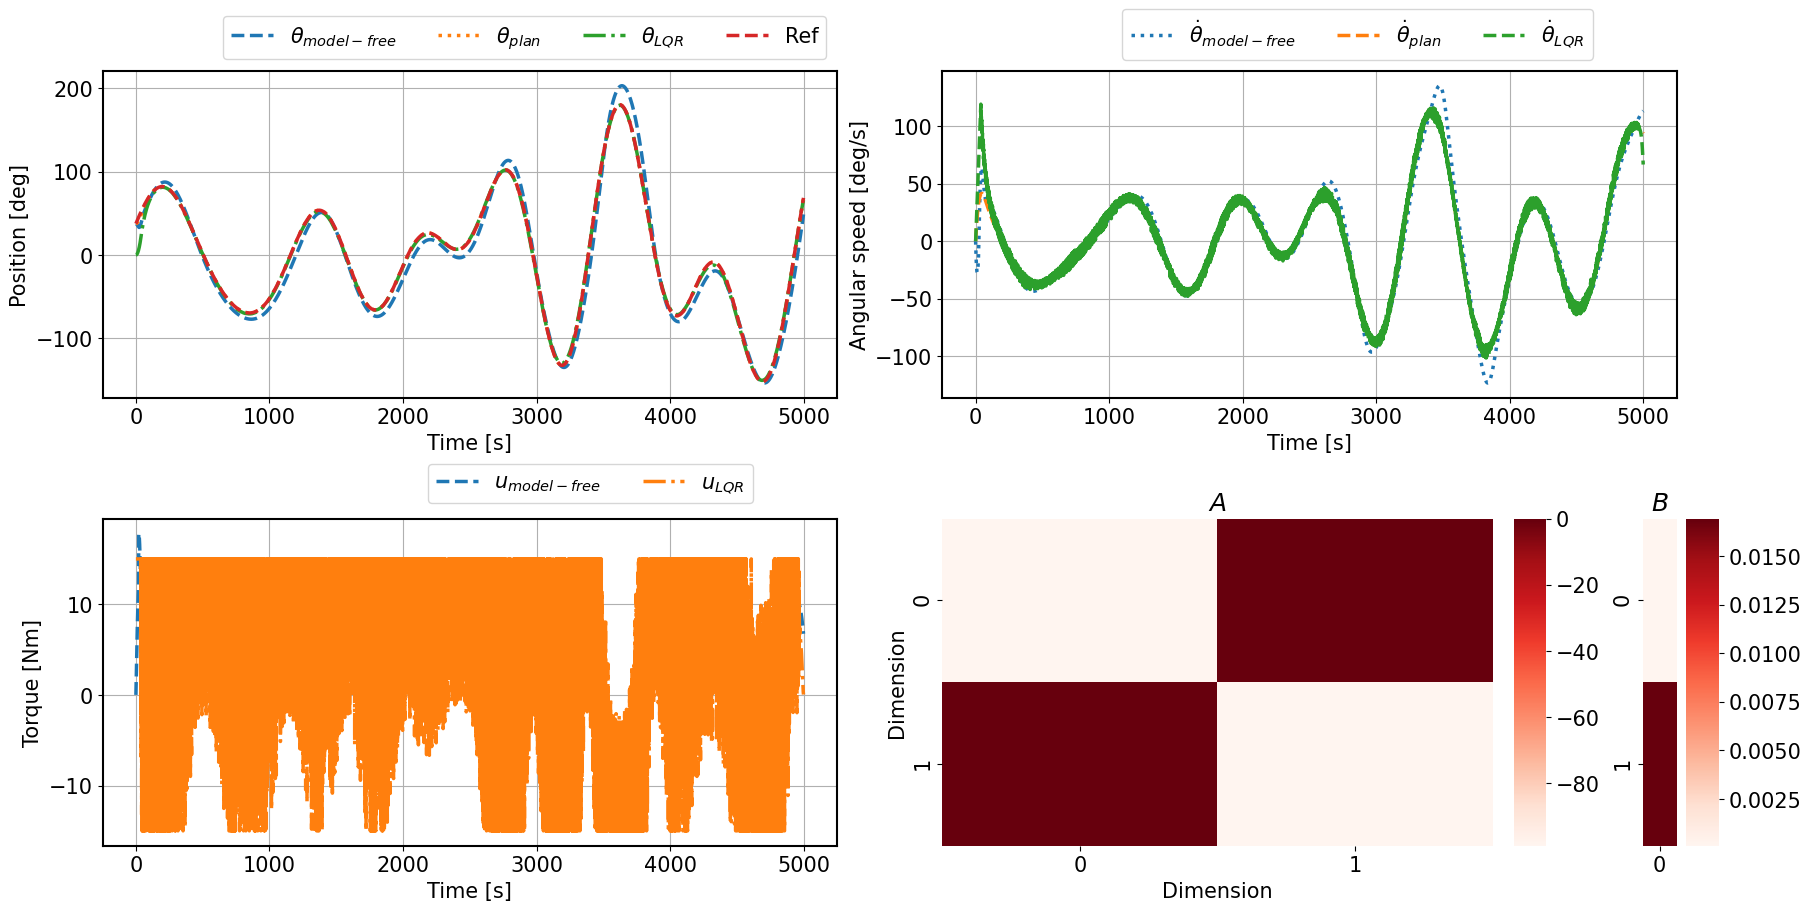

In [344]:
X0 = pend.X0
Xc, X_lift = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.lift_dim,model.N])
Uc, K = np.empty(shape=[model.N-1]), model.K[:,0,:]
t_interval = pend.dt
U_true = np.empty(shape=[model.N-1])

# Initial condition
Xc[:,0] = X0
N = np.eye(model.lift_dim) - pinv(model.C) @ model.C
X0_lift = pinv(model.C)@X0
X0_lift = X0_lift + N@(model.X_lift[:,0] - X0_lift) # Nullspace projection into subspace 
X_lift[:,0] = X0_lift

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model.N-1):
    
    Uc[i] = (model.LQR.get_command(X_lift[:,i],i))
    U_true[i] = Uc[i]
#     Uc[i] = -K[i,:]@(Xc[:,i] - np.array([pend.ref[traj,i],0]))
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    X_lift[:,i+1] = pinv(model.C)@Xc[:,i+1]
    
print('LQR cost : ',model.LQR_cost(Xc, Uc, pend.ref[traj,:]))
print('LQR cost : ',model.LQR_cost(pend.X[traj,:,:], pend.U[traj,:], pend.ref[traj,:]))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:7])
ax11_1 = fig.add_subplot(gs[4:8,7:8])

ax00.plot(pend.T, rad2deg(pend.X[traj,0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model.LQR_X[:,0]), linestyle=':', label=r'$\theta_{plan}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{LQR}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[traj,1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model.N-1], pend.U[traj,:], linestyle='dashed', label='$u_{model-free}$')
# ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{plan}$')
ax10.plot(pend.T[:model.N-1], Uc, linestyle='dashdot', label='$u_{LQR}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model.A - np.eye(model.A.shape[0])/pend.dt,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model.B/pend.dt,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
# fig.savefig('Images/Midterm/summary.png',dpi=800)

In [345]:
print(model.RMSE(Uc,pend.U[traj]))
print(lg.norm(Uc[:,np.newaxis].T - pend.U[traj,:,np.newaxis].T, ord=2, axis=0).shape)
# X_true_norm = lg.norm(X_true, ord=2, axis=0)
# 100*delta_X_norm.sum()/X_true_norm.sum()
print(U_true[0:100])

140.58245387571458
(4999,)
[ 8.57771e+02  8.46111e+02  8.33933e+02  8.21238e+02  8.08023e+02
  7.94289e+02  7.80035e+02  7.65262e+02  7.49967e+02  7.34149e+02
  7.17808e+02  7.00943e+02  6.83550e+02  6.65628e+02  6.47174e+02
  6.28186e+02  6.08660e+02  5.88592e+02  5.67977e+02  5.46811e+02
  5.25088e+02  5.02802e+02  4.79945e+02  4.56511e+02  4.32491e+02
  4.07875e+02  3.82654e+02  3.56816e+02  3.30350e+02  3.03242e+02
  2.75478e+02  2.47044e+02  2.17923e+02  1.88097e+02  1.57548e+02
  1.26256e+02  9.41980e+01  6.13523e+01  2.76940e+01 -6.80285e+00
  3.20296e+01 -2.12099e+00  2.10989e+01 -1.32094e+01  4.75560e+01
  1.41028e+01 -1.72332e+01  4.95924e+01  1.62441e+01 -1.80721e+01
  4.87081e+01  1.52839e+01 -1.91385e+01  4.75056e+01  1.39173e+01
 -1.70125e+01  4.95172e+01  1.57909e+01 -1.89850e+01  4.72543e+01
  1.32135e+01 -1.58214e+01  5.02290e+01  1.59803e+01 -1.93613e+01
  4.62689e+01  1.15779e+01 -1.25823e+01  4.46671e+01  9.57369e+00
 -8.18745e+00  3.38600e+01 -1.92246e+00  1.87259e